In [1]:
!pip install patchify
#!pip install segmentation_models
!pip install geoTiff
#!pip install -U segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.8/185.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 35.6 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=fff925186aad9d718230f3ee9fbd88cafd0bbf78b3e0f4745845dd8f908c6c03
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [2]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-1j8tr4v1
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-1j8tr4v1
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33786 sha256=11288b5f2f8d37a1f817cb63fdb404a24bc0a3e0143015e8745d7432911ccd4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-4_swix5g/wheels/ce/d6/f1/5d00e82b3893c5f1ffee43bf7b8877148af09c7c9c6c4882c9
Successfully built segmentation-models


In [3]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
#Switch to directory on google drive
%cd '/content/gdrive/MyDrive/NUST MSDS/Processed_Data'

/content/gdrive/MyDrive/NUST MSDS/Processed_Data


In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, ZeroPadding2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

def conv_block(input_tensor, filters, kernel_size, strides=(1, 1), padding='valid'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def identity_block(input_tensor, filters, kernel_size):
    filters1, filters2, filters3 = filters

    x = conv_block(input_tensor, filters1, (1, 1))
    x = conv_block(x, filters2, kernel_size, padding='same')
    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    if input_tensor.shape[-1] != filters3:
        input_tensor = Conv2D(filters3, (1, 1))(input_tensor)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x

def conv_block_stride(input_tensor, filters, kernel_size):
    filters1, filters2, filters3 = filters

    x = conv_block(input_tensor, filters1, (1, 1), strides=(2, 2), padding='same')
    x = conv_block(x, filters2, kernel_size, padding='same')
    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)

    shortcut = Conv2D(filters3, (1, 1), strides=(2, 2))(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def resnet50_base(input_shape):
    input_tensor = Input(shape=input_shape)

    x = ZeroPadding2D((3, 3))(input_tensor)

    # Stage 1
    x = conv_block_stride(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))
    x = identity_block(x, [64, 64, 256], (3, 3))

    # Stage 2
    x = conv_block_stride(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))
    x = identity_block(x, [128, 128, 512], (3, 3))

    # Stage 3
    x = conv_block_stride(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))
    x = identity_block(x, [256, 256, 1024], (3, 3))

    # Stage 4
    x = conv_block_stride(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))
    x = identity_block(x, [512, 512, 2048], (3, 3))

    model = Model(inputs=input_tensor, outputs=x)
    return model

def deeplabv3plus(input_shape, num_classes):
    input_tensor = Input(shape=input_shape)

    # Create the base model using ResNet50 without top layers
    base_model = resnet50_base(input_shape)
    base_model_output = base_model(input_tensor)

    # Intermediate convolutional layers
    x = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(base_model_output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Decoder
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output layer
    output = Conv2DTranspose(num_classes, (3, 3), strides=(2, 2), padding='same', activation='softmax')(x)
    output = tf.image.resize(output, (input_shape[0], input_shape[1]))

    # Create the model
    model = Model(inputs=input_tensor, outputs=output)

    return model

# Create the DeepLabv3+ model with the custom ResNet50 base
# input_shape = (256, 256, 8)
# num_classes = 4
# model = deeplabv3plus(input_shape, num_classes)
# model.summary()


In [6]:
import os
import cv2
import numpy as np
import io
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import tensorflow as tf
from geotiff import GeoTiff


from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()


In [7]:
pwd

'/content/gdrive/MyDrive/NUST MSDS/Processed_Data'

In [8]:
root_directory = r"/content/gdrive/MyDrive/NUST MSDS/Processed_Data"

patch_size = 256

images_shapes = []
mask_shapes = []

count_images = 0
count_masks = 0

#image_details = []
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.
image_dataset = []
image_details = []
mask_dataset = []
mask_details = []
for path, subdirs, files in os.walk(root_directory):
    print(path)
    dirname = path.split(os.path.sep)[-1]
    #if dirname == 'images_raw_fixed' and (path.find('Massan') != -1):   #Find all 'images' directories
    if dirname == 'images_raw_fixed':
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".tif"):   #Only read jpg images...
                image_path = path + '/' + image_name
                image = GeoTiff(image_path)  #Read each image as BGR
                image = image.read()
                image = image[:, :, 0:7]
                image = np.array(image)
                # NEW for 3 channel image
                # image = image[:, :, 0:3]
                # image = np.array(image)
                # NEW for 3 channel image end
                #print(image_name)
                #End Convert to RGB
                #image = open_image(path+"/"+image_name)
                count_images = count_images + 1
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size

                patches_img = patchify(image, (patch_size, patch_size, 7), step=patch_size)  #Step=256 for 256 patches means no overlap
                #patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
                num_patches = 0
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        image_dataset.append(single_patch_img)
                        num_patches = num_patches + 1

                image_details.append((count_images, image_name, num_patches))

                mask_name = image_name
                mask_path = path.replace('images_raw_fixed', 'masks_4class')
                mask = GeoTiff(mask_path+"/"+image_name)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = mask.read()
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = np.array(mask)

                mask = mask[:, :, 0:3]

                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                num_patches = 0
                count_masks = count_masks + 1
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        mask_dataset.append(single_patch_mask)
                        num_patches = num_patches + 1

                mask_details.append((count_masks, mask_name, num_patches))

mask_dataset =  np.array(mask_dataset)
image_dataset = np.array(image_dataset)

/content/gdrive/MyDrive/NUST MSDS/Processed_Data
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs/train
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs/validation
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_raw_fixed
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_raw_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_fixed
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_fixed_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_b_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_b
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_rgb
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_rgb_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_4clas

In [9]:
print(mask_dataset.shape)
print(image_dataset.shape)

(742, 256, 256, 3)
(742, 256, 256, 7)


In [10]:
# i = 0
# for val in image_details:
#   print(image_details[i], ' ', mask_details[i])
#   i = i +1

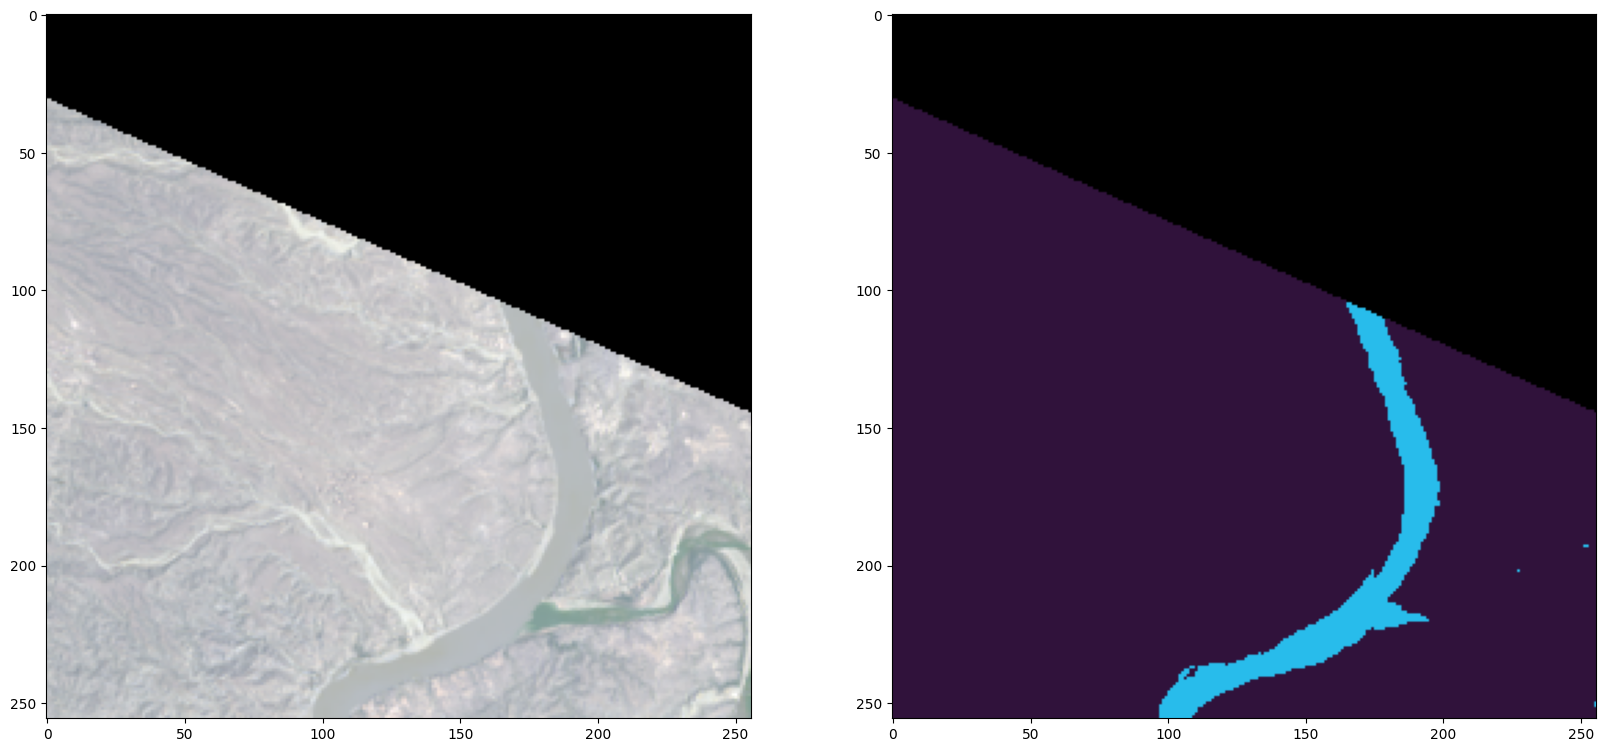

In [11]:
_
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(20, 10))
plt.subplot(121)
# plot_image_R = np.array(image_dataset[image_number,:,:,2])
# plot_image_G = np.array(image_dataset[image_number,:,:,1])
# plot_image_B = np.array(image_dataset[image_number,:,:,0])
plot_image_R = np.array(image_dataset[image_number,:,:,3])
plot_image_G = np.array(image_dataset[image_number,:,:,2])
plot_image_B = np.array(image_dataset[image_number,:,:,1])
plot_image = np.dstack((plot_image_R, plot_image_G, plot_image_B))
plot_image = (plot_image * 255.999) .astype(np.uint8)
#plt.imshow(plot_image, (patch_size, patch_size, 3)))
plt.imshow(plot_image)
plt.subplot(122)
#plt.imshow(np.reshape(mask_dataset[image_number,:,:,:3], (patch_size, patch_size, 3)))
#plt.imshow(mask_dataset[image_number])
plt.imshow(np.reshape(mask_dataset[image_number,:,:,:3], (patch_size, patch_size, 3)))
plt.savefig('New_Models/Deeplabv3plus/Sample_1.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Sample_1.pdf', format='pdf')
plt.show()

In [12]:
#Do the same for all RGB channels in each hex code to convert to RGB

contaminated = '#FB7E21'.lstrip('#')
contaminated = np.array(tuple(int(contaminated[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

clear = '#28BCEB'.lstrip('#')
clear = np.array(tuple(int(clear[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

nowater = '#30123B'.lstrip('#')
nowater = np.array(tuple(int(nowater[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

nodata = '#000000'.lstrip('#')
nodata = np.array(tuple(int(nodata[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

label = single_patch_mask

In [13]:

# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label==nodata,axis=-1)] = 0
    label_seg [np.all(label==nowater,axis=-1)] = 1
    label_seg [np.all(label == clear,axis=-1)] = 2
    label_seg [np.all(label==contaminated,axis=-1)] = 3


    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


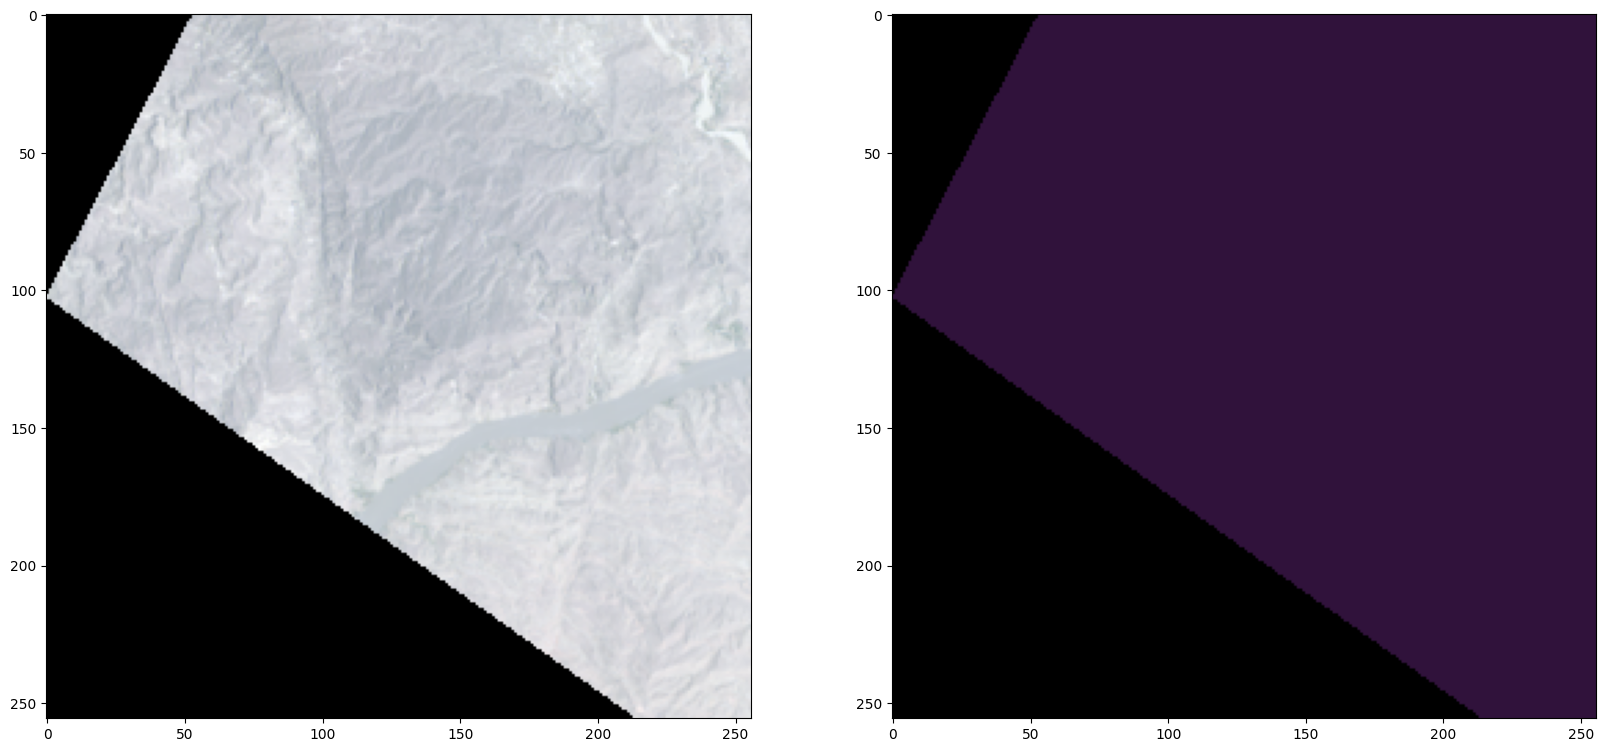

In [14]:

#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(20, 10))
plt.subplot(121)
# plot_image_R = np.array(image_dataset[image_number,:,:,2])
# plot_image_G = np.array(image_dataset[image_number,:,:,1])
# plot_image_B = np.array(image_dataset[image_number,:,:,0])
plot_image_R = np.array(image_dataset[image_number,:,:,3])
plot_image_G = np.array(image_dataset[image_number,:,:,2])
plot_image_B = np.array(image_dataset[image_number,:,:,1])
plot_image = np.dstack((plot_image_R, plot_image_G, plot_image_B))
plot_image = (plot_image * 255.999) .astype(np.uint8)
#plt.imshow(plot_image, (patch_size, patch_size, 3)))
plt.imshow(plot_image)
plt.subplot(122)
#plt.imshow(labels[image_number][:,:,0])
plt.imshow(np.reshape(mask_dataset[image_number,:,:,:3], (patch_size, patch_size, 3)))
plt.savefig('New_Models/Deeplabv3plus/Sample_2.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Sample_2.pdf', format='pdf')
plt.show()

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
batch_size = 32
# Example dataset shapes

# Split dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

# # Create an instance of ImageDataGenerator for data augmentation
# augmentation_datagen = ImageDataGenerator(
#     rotation_range=10,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     fill_mode='nearest'
# )

# # Create an instance of ImageDataGenerator for data validation (no augmentation)
# validation_datagen = ImageDataGenerator()

# # Generate augmented training data
# augmented_train_generator = augmentation_datagen.flow(
#     X_train,
#     y_train,
#     batch_size=batch_size,
#     seed=42
# )

# # Generate validation data (no augmentation)
# validation_generator = validation_datagen.flow(
#     X_val,
#     y_val,
#     batch_size=batch_size,
#     seed=42
# )

In [16]:
X_train.shape

(593, 256, 256, 7)

In [17]:
#######################################
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
from sklearn.utils.class_weight import compute_class_weight

#eights = compute_class_weight('balanced', np.unique(np.ravel(labels,order='C')),
#                               np.ravel(labels,order='C'))
unique_labels, label_counts = np.unique(labels, return_counts=True)
total_samples = len(labels)
class_weights = total_samples / (len(unique_labels) * label_counts)
weights = dict(zip(unique_labels, class_weights))



print(weights)
#from sklearn.utils import class_weight
#weights = [0.2,0.2, 0.2, 0.2, 0.2, 0.1]
#class_weights = class_weight.compute_class_weight('balanced',
#                                                 n_classes,
#                                                 y_train)
#dice_loss = sm.losses.DiceLoss(class_weights=weights)
#focal_loss = sm.losses.CategoricalFocalLoss()
#total_loss = dice_loss + (1 * focal_loss)  #
#total_loss = focal_loss

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

{0: 1.6931925899320303e-05, 1: 5.041234444224828e-06, 2: 0.0003263581248218665, 3: 0.0006039591065963404}


In [18]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#class_weights = [5.179519420733717e-06, 0.0004351441664291554, 0.0008052788087951206]
def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    class_weights = [1.6931925899320303e-05, 5.041234444224828e-06, 0.0003263581248218665, 0.0006039591065963404]

    """
    Compute weighted Dice loss.
    :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
    :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
    :return: Weighted Dice loss (tf.Tensor, shape=(None,))
    """
    axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
    numerator = y_true * y_pred * class_weights  # Broadcasting
    numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

    denominator = (y_true + y_pred) * class_weights # Broadcasting
    denominator = K.sum(denominator, axis=axis_to_reduce)

    return 1 - numerator / denominator

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


In [19]:
# #Loading a crashed model and training it again, save the previous log and append it with new log to get the output
# del image_dataset
# del mask_dataset
# del label
# from keras.models import load_model
# metrics=['accuracy', jacard_coef, dice_coef, recall_m, precision_m, f1_m ]
# my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min'),
#     tf.keras.callbacks.ModelCheckpoint(filepath='New_Models/Deeplabv3plus2/model.{epoch:02d}-{loss:.2f}.h5', save_best_only=True, monitor='loss', mode='min'),
#     tf.keras.callbacks.TensorBoard(log_dir='New_Models/Deeplabv3plus2/logs')]
# model = load_model("/content/gdrive/MyDrive/NUST MSDS/Processed_Data/New_Models/Deeplabv3plus/model.99-0.17.h5",
#                    custom_objects={"loss": loss,"jacard_coef": jacard_coef, "dice_coef": dice_coef,"recall_m": recall_m, "precision_m": precision_m, "f1_m": f1_m, "dice_coef_loss": dice_coef_loss})
# history1 = model.fit(X_train, y_train,
#                     batch_size=8,
#                     verbose=1,
#                     epochs=101,
#                     validation_data=(X_val, y_val),
#                     shuffle=True,
#                     callbacks=my_callbacks)

In [20]:
#metrics=['accuracy', jacard_coef, dice_coef, dice_coef_loss, recall_m, precision_m, f1_m ]
metrics=['accuracy', jacard_coef, dice_coef, recall_m, precision_m, f1_m ]
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10, mode='min'),
    tf.keras.callbacks.ModelCheckpoint(filepath='New_Models/Deeplabv3plus/7chmodel.{epoch:02d}-{loss:.2f}.h5', save_best_only=True, monitor='loss', mode='min'),
    tf.keras.callbacks.TensorBoard(log_dir='New_Models/Deeplabv3plus/logs')]

In [21]:
def get_model():
    return deeplabv3plus((256, 256, 7), 4)
model = get_model()
#model.compile(optimizer='adam', loss='mse', metrics=metrics)
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='rmsprop', loss=total_loss, metrics=metrics)
import tensorflow as tf
tf.random.set_seed(48)
from tensorflow import keras
#opt = keras.optimizers.Adam(learning_rate=0.0001)
opt = keras.optimizers.Adam(learning_rate=0.1e-4)
#opt = keras.optimizers.Adam(learning_rate=0.00001)

#model.compile(optimizer=opt, loss=total_loss, metrics=metrics)
#model.compile(optimizer=opt, loss=dice_coef_loss, metrics=metrics)
model.compile(optimizer=opt, loss=loss, metrics=metrics)
model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 7)]     0         
                                                                 
 model (Functional)          (None, 17, 17, 2048)      23559744  
                                                                 
 conv2d_52 (Conv2D)          (None, 17, 17, 256)       524544    
                                                                 
 batch_normalization_52 (Ba  (None, 17, 17, 256)       1024      
 tchNormalization)                                               
                                                                 
 activation_48 (Activation)  (None, 17, 17, 256)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 34, 34, 256)       590080    
 anspose)                                                  

In [22]:
# history1 = model.fit(augmented_train_generator,
#                     verbose=1,
#                     epochs=100,
#                     validation_data=validation_generator,
#                     callbacks=my_callbacks)


In [ ]:
# # history1 = model.fit(X_train, y_train,
# #                     batch_size=16,
# #                     verbose=2,
# #                     epochs=200,
# #                     validation_data=(X_val, y_val),
# #                     shuffle=False,
# #                     callbacks=my_callbacks)

# #weights =  np.array([0.000005179519420733717, 0.0004351441664291554, 0.0008052788087951206])

history1 = model.fit(X_train, y_train,
                    batch_size=8,
                    verbose=1,
                    epochs=150,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=my_callbacks)


Epoch 1/150
75/75 [==============================] - ETA: 0s - loss: 0.9658 - accuracy: 0.2044 - jacard_coef: 0.1388 - dice_coef: 0.6512 - recall_m: 0.0139 - precision_m: 0.1273 - f1_m: 0.0242

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 110s 742ms/step - loss: 0.9658 - accuracy: 0.2044 - jacard_coef: 0.1388 - dice_coef: 0.6512 - recall_m: 0.0139 - precision_m: 0.1273 - f1_m: 0.0242 - val_loss: 0.9670 - val_accuracy: 0.2273 - val_jacard_coef: 0.1407 - val_dice_coef: 0.6619 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_f1_m: 0.0000e+00
Epoch 2/150
75/75 [==============================] - 50s 662ms/step - loss: 0.9369 - accuracy: 0.4978 - jacard_coef: 0.2330 - dice_coef: 0.7335 - recall_m: 0.2517 - precision_m: 0.6285 - f1_m: 0.3534 - val_loss: 0.9456 - val_accuracy: 0.2273 - val_jacard_coef: 0.1371 - val_dice_coef: 0.6084 - val_recall_m: 0.2168 - val_precision_m: 0.2229 - val_f1_m: 0.2198
Epoch 3/150
75/75 [==============================] - 50s 671ms/step - loss: 0.8859 - accuracy: 0.7270 - jacard_coef: 0.3707 - dice_coef: 0.8220 - recall_m: 0.5465 - precision_m: 0.7924 - f1_m: 0.6454 - val_loss: 0.8917 - val_accuracy: 0.2273 - val_jacard_coef: 0.1285 - val_dice_

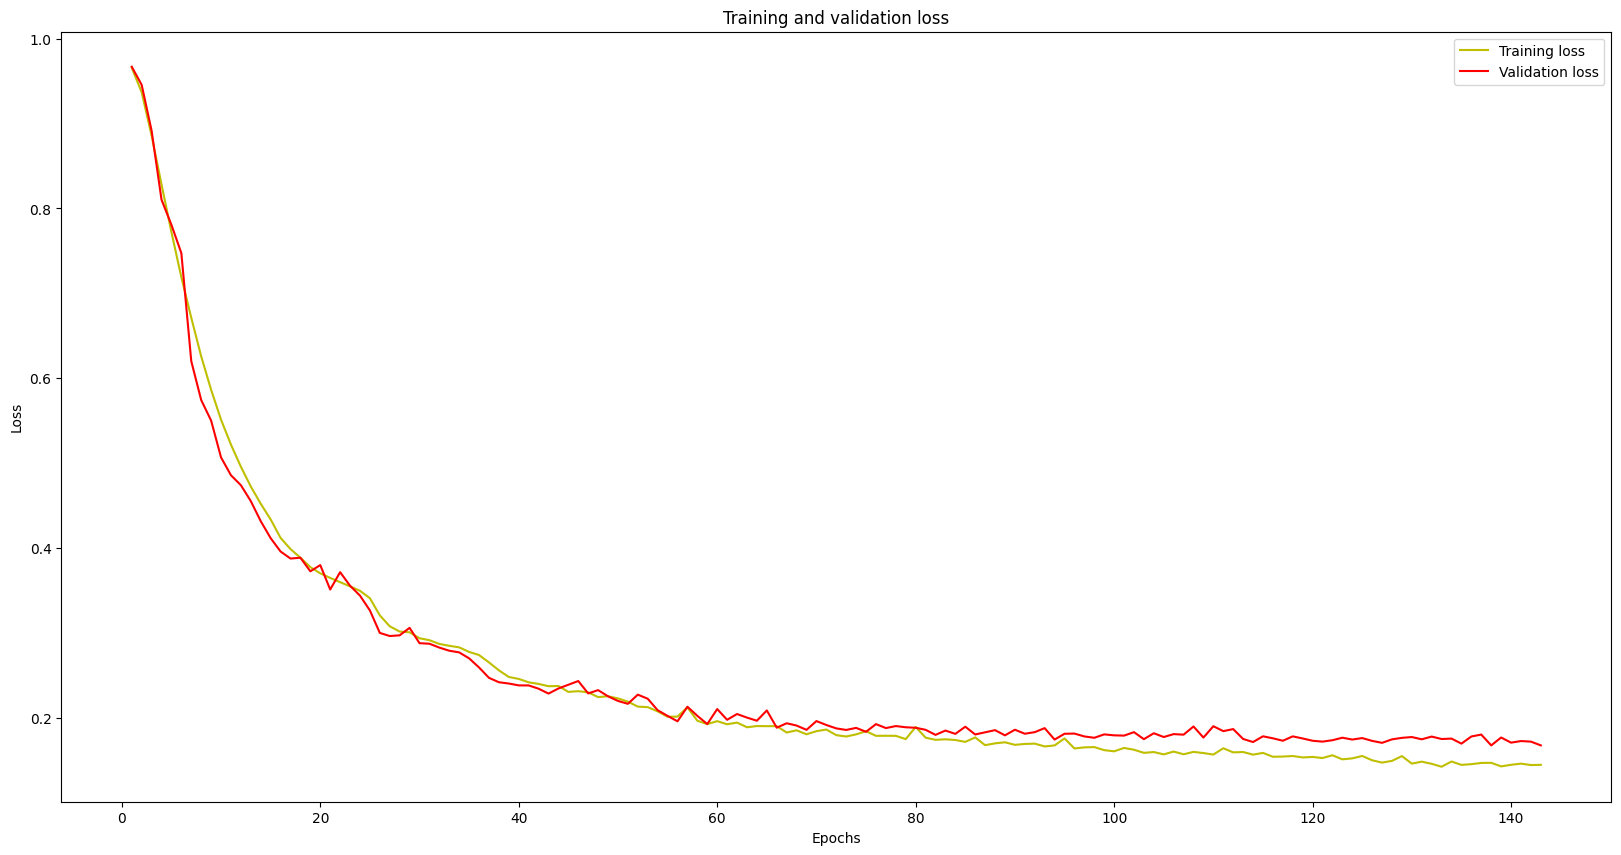

In [ ]:
###########################################################
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(20, 10))
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/Train_val_loss_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Train_val_loss_Deeplabv3plus.pdf')
plt.show()


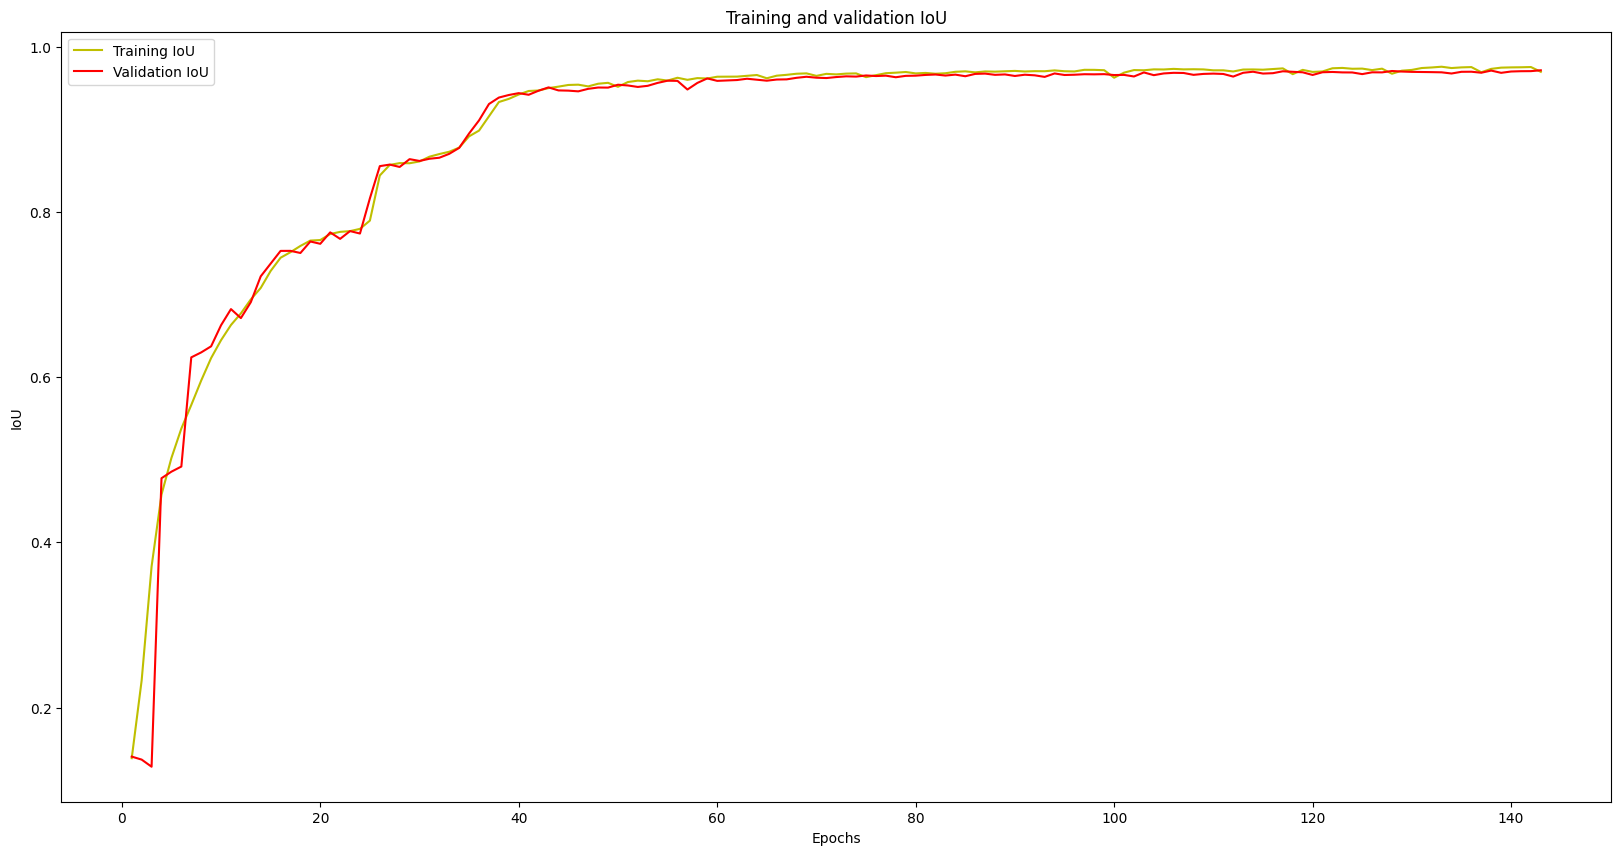

In [ ]:
jcoef = history.history['jacard_coef']
val_jcoef = history.history['val_jacard_coef']
plt.figure(figsize=(20, 10))
plt.plot(epochs, jcoef, 'y', label='Training IoU')
plt.plot(epochs, val_jcoef, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/Train_val_IoU_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Train_val_IoU_Deeplabv3plus.pdf')
plt.show()


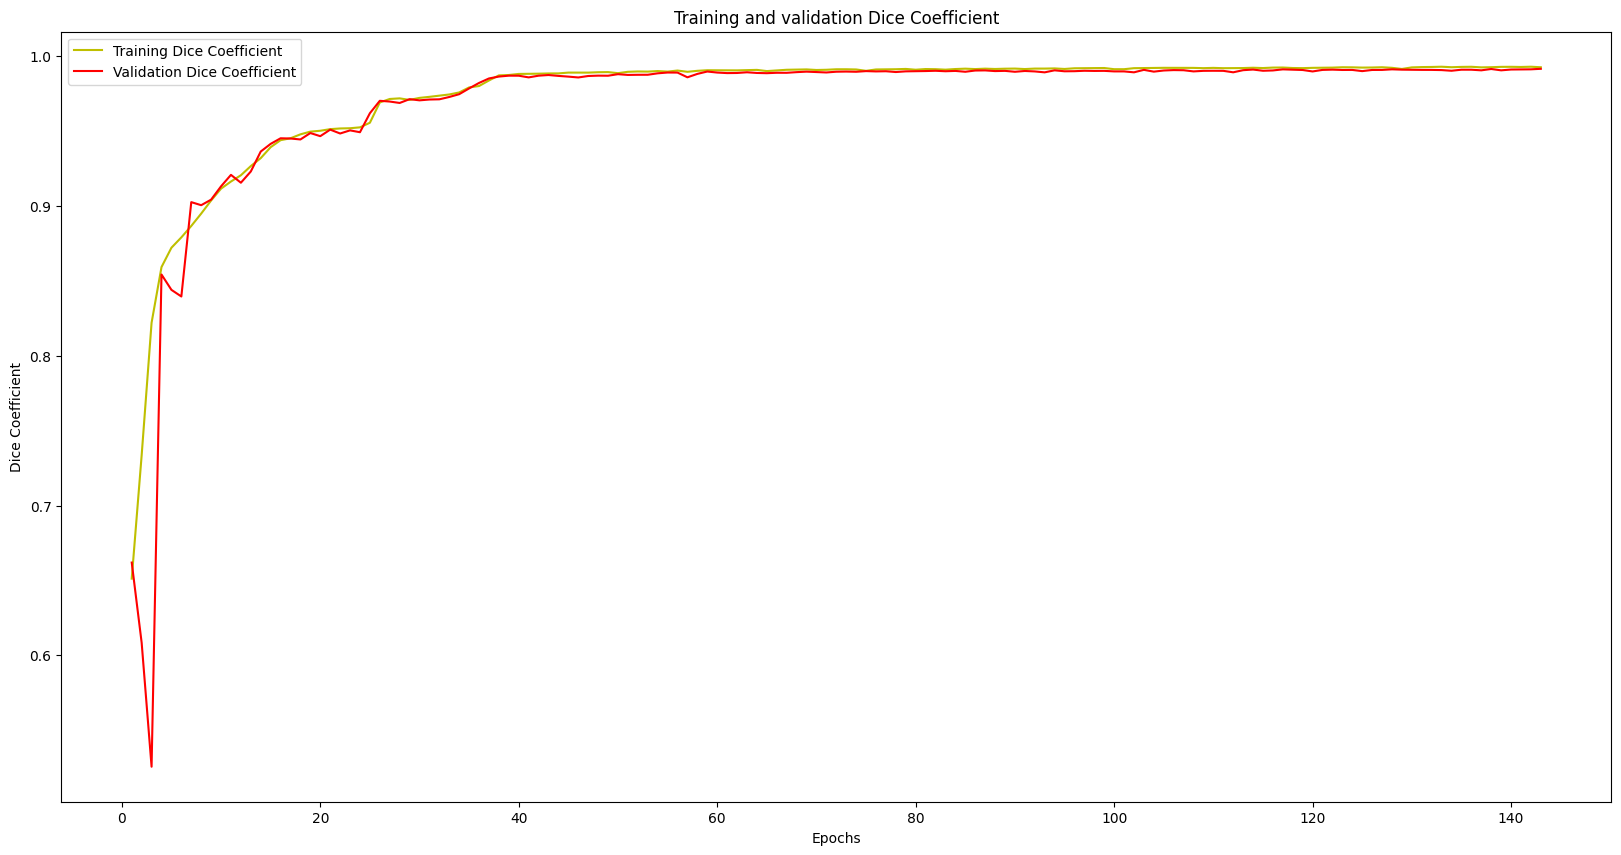

In [ ]:
dcoef = history1.history['dice_coef']
val_dcoef = history1.history['val_dice_coef']
plt.figure(figsize=(20, 10))
plt.plot(epochs, dcoef, 'y', label='Training Dice Coefficient')
plt.plot(epochs, val_dcoef, 'r', label='Validation Dice Coefficient')
plt.title('Training and validation Dice Coefficient')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/Dice_coef_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Dice_coef_Deeplabv3plus.png', format='png')
plt.show()

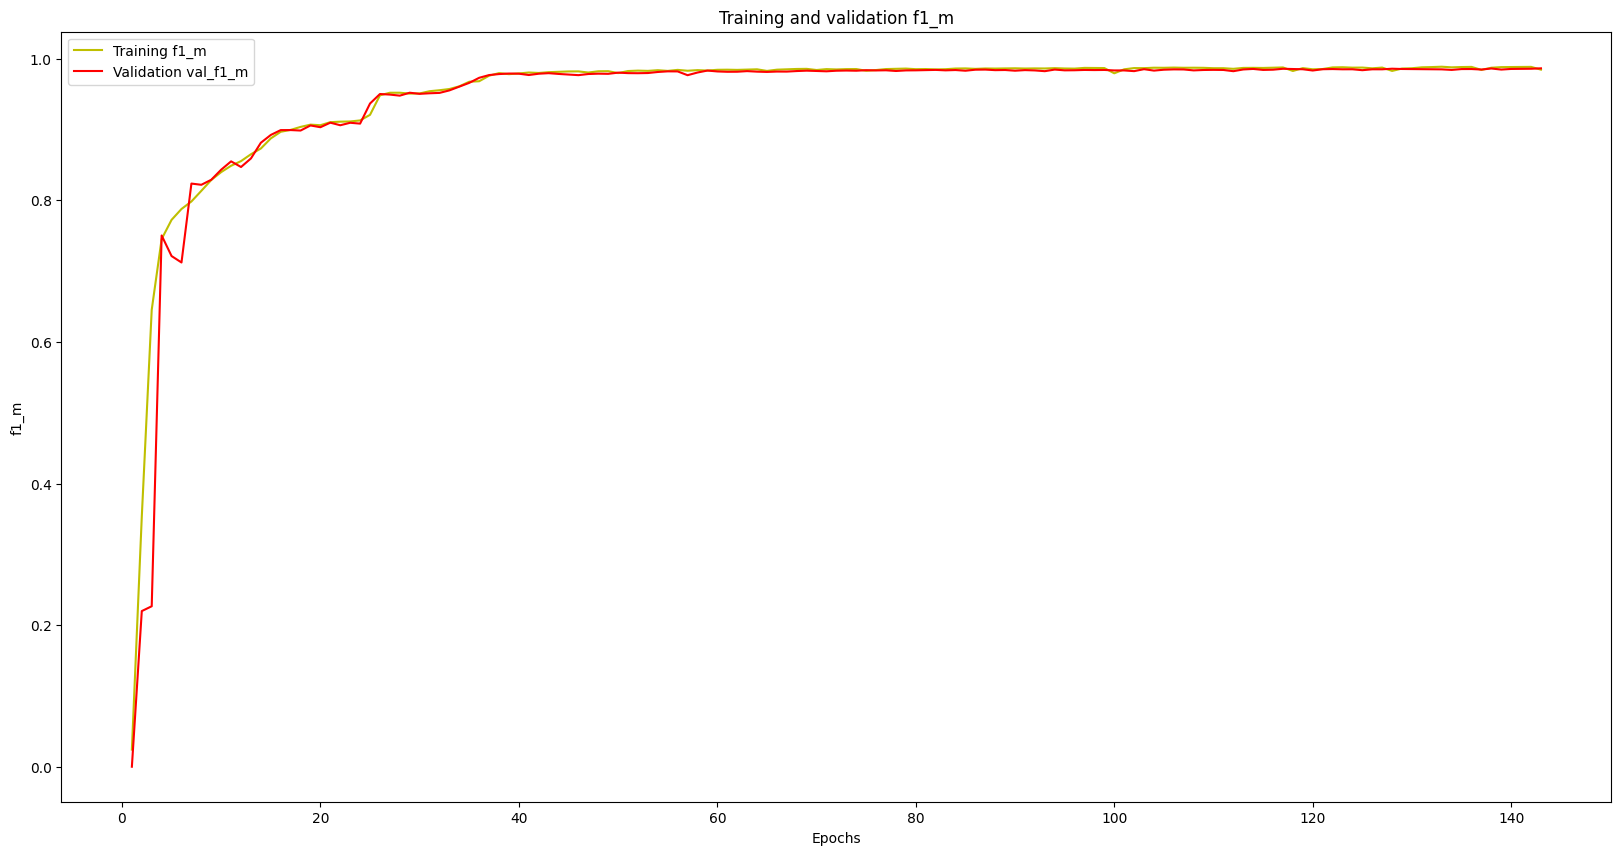

In [ ]:
f1_m = history1.history['f1_m']
val_f1_m = history1.history['val_f1_m']
plt.figure(figsize=(20, 10))
plt.plot(epochs, f1_m, 'y', label='Training f1_m')
plt.plot(epochs, val_f1_m, 'r', label='Validation val_f1_m')
plt.title('Training and validation f1_m')
plt.xlabel('Epochs')
plt.ylabel('f1_m')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/F1_m_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/F1_m_Deeplabv3plus.png', format='png')
plt.show()


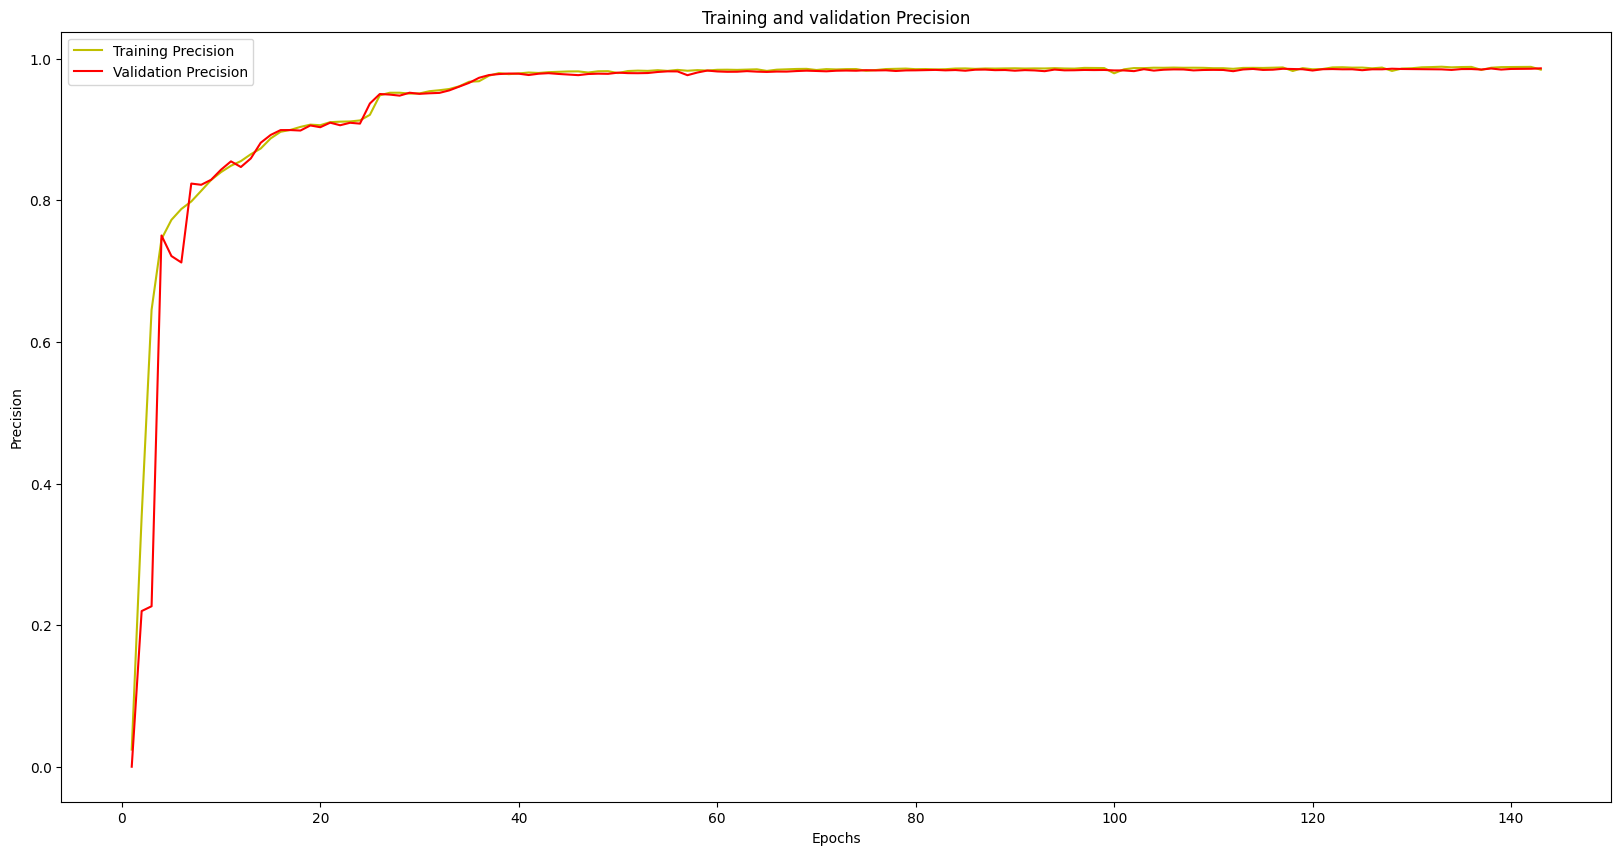

In [ ]:
pre_m = history1.history['precision_m']
val_pre_m = history1.history['val_precision_m']
plt.figure(figsize=(20, 10))
plt.plot(epochs, f1_m, 'y', label='Training Precision')
plt.plot(epochs, val_f1_m, 'r', label='Validation Precision')
plt.title('Training and validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/Precision_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Precision_Deeplabv3plus.png', format='png')
plt.show()


### Predictions

In [ ]:
# MIT License
# Copyright (c) 2017 Vooban Inc.
# Coded by: Guillaume Chevalier
# Source to original code and license:
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches
#     https://github.com/Vooban/Smoothly-Blend-Image-Patches/blob/master/LICENSE


"""Do smooth predictions on an image from tiled prediction patches."""


import numpy as np
import scipy.signal
from tqdm import tqdm

import gc

PLOT_PROGRESS = False
def _spline_window(window_size, power=2):
    """
    Squared spline (power=2) window function:
    https://www.wolframalpha.com/input/?i=y%3Dx**2,+y%3D-(x-2)**2+%2B2,+y%3D(x-4)**2,+from+y+%3D+0+to+2
    """
    intersection = int(window_size/4)
    wind_outer = (abs(2*(scipy.signal.triang(window_size))) ** power)/2
    wind_outer[intersection:-intersection] = 0

    wind_inner = 1 - (abs(2*(scipy.signal.triang(window_size) - 1)) ** power)/2
    wind_inner[:intersection] = 0
    wind_inner[-intersection:] = 0

    wind = wind_inner + wind_outer
    wind = wind / np.average(wind)
    return wind


cached_2d_windows = dict()
def _window_2D(window_size, power=2):
    """
    Make a 1D window function, then infer and return a 2D window function.
    Done with an augmentation, and self multiplication with its transpose.
    Could be generalized to more dimensions.
    """
    # Memoization
    global cached_2d_windows
    key = "{}_{}".format(window_size, power)
    if key in cached_2d_windows:
        wind = cached_2d_windows[key]
    else:
        wind = _spline_window(window_size, power)
        #wind = np.expand_dims(np.expand_dims(wind, 3), 3)
        wind = np.expand_dims(np.expand_dims(wind, 1), 1)
        wind = wind * wind.transpose(1, 0, 2)
        if PLOT_PROGRESS:
            # For demo purpose, let's look once at the window:
            plt.imshow(wind[:, :, 0], cmap="viridis")
            plt.title("2D Windowing Function for a Smooth Blending of "
                      "Overlapping Patches")
            plt.show()
        cached_2d_windows[key] = wind
    return wind


def _pad_img(img, window_size, subdivisions):
    """
    Add borders to img for a "valid" border pattern according to "window_size" and
    "subdivisions".
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    more_borders = ((aug, aug), (aug, aug), (0, 0))
    ret = np.pad(img, pad_width=more_borders, mode='reflect')
    # gc.collect()

    if PLOT_PROGRESS:
        # For demo purpose, let's look once at the window:
        plt.imshow(ret)
        plt.title("Padded Image for Using Tiled Prediction Patches\n"
                  "(notice the reflection effect on the padded borders)")
        plt.show()
    return ret


def _unpad_img(padded_img, window_size, subdivisions):
    """
    Undo what's done in the `_pad_img` function.
    Image is an np array of shape (x, y, nb_channels).
    """
    aug = int(round(window_size * (1 - 1.0/subdivisions)))
    ret = padded_img[
        aug:-aug,
        aug:-aug,
        :
    ]
    # gc.collect()
    return ret


def _rotate_mirror_do(im):
    """
    Duplicate an np array (image) of shape (x, y, nb_channels) 8 times, in order
    to have all the possible rotations and mirrors of that image that fits the
    possible 90 degrees rotations.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    mirrs = []
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    im = np.array(im)[:, ::-1]
    mirrs.append(np.array(im))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=1))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=2))
    mirrs.append(np.rot90(np.array(im), axes=(0, 1), k=3))
    return mirrs


def _rotate_mirror_undo(im_mirrs):
    """
    merges a list of 8 np arrays (images) of shape (x, y, nb_channels) generated
    from the `_rotate_mirror_do` function. Each images might have changed and
    merging them implies to rotated them back in order and average things out.

    It is the D_4 (D4) Dihedral group:
    https://en.wikipedia.org/wiki/Dihedral_group
    """
    origs = []
    origs.append(np.array(im_mirrs[0]))
    origs.append(np.rot90(np.array(im_mirrs[1]), axes=(0, 1), k=3))
    origs.append(np.rot90(np.array(im_mirrs[2]), axes=(0, 1), k=2))
    origs.append(np.rot90(np.array(im_mirrs[3]), axes=(0, 1), k=1))
    origs.append(np.array(im_mirrs[4])[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[5]), axes=(0, 1), k=3)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[6]), axes=(0, 1), k=2)[:, ::-1])
    origs.append(np.rot90(np.array(im_mirrs[7]), axes=(0, 1), k=1)[:, ::-1])
    return np.mean(origs, axis=0)


def _windowed_subdivs(padded_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Create tiled overlapping patches.

    Returns:
        5D numpy array of shape = (
            nb_patches_along_X,
            nb_patches_along_Y,
            patches_resolution_along_X,
            patches_resolution_along_Y,
            nb_output_channels
        )

    Note:
        patches_resolution_along_X == patches_resolution_along_Y == window_size
    """
    WINDOW_SPLINE_2D = _window_2D(window_size=window_size, power=2)

    step = int(window_size/subdivisions)
    padx_len = padded_img.shape[0]
    pady_len = padded_img.shape[1]
    subdivs = []

    for i in range(0, padx_len-window_size+1, step):
        subdivs.append([])
        #for j in range(0, padx_len-window_size+1, step):
        for j in range(0, pady_len-window_size+1, step):
            patch = padded_img[i:i+window_size, j:j+window_size, :]
            subdivs[-1].append(patch)

    # Here, `gc.collect()` clears RAM between operations.
    # It should run faster if they are removed, if enough memory is available.
    gc.collect()
    subdivs = np.array(subdivs)
    gc.collect()
    a, b, c, d, e = subdivs.shape
    subdivs = subdivs.reshape(a * b, c, d, e)
    gc.collect()

    subdivs = pred_func(subdivs)
    gc.collect()
    subdivs = np.array([patch * WINDOW_SPLINE_2D for patch in subdivs])
    gc.collect()

    # Such 5D array:
    subdivs = subdivs.reshape(a, b, c, d, nb_classes)
    gc.collect()

    return subdivs


def _recreate_from_subdivs(subdivs, window_size, subdivisions, padded_out_shape):
    """
    Merge tiled overlapping patches smoothly.
    """
    step = int(window_size/subdivisions)
    padx_len = padded_out_shape[0]
    pady_len = padded_out_shape[1]

    y = np.zeros(padded_out_shape)

    a = 0
    for i in range(0, padx_len-window_size+1, step):
        b = 0
        #for j in range(0, padx_len-window_size+1, step):
        for j in range(0, pady_len-window_size+1, step):
            windowed_patch = subdivs[a, b]
            y[i:i+window_size, j:j+window_size] = y[i:i+window_size, j:j+window_size] + windowed_patch
            b += 1
        a += 1
    return y / (subdivisions ** 2)


def predict_img_with_smooth_windowing(input_img, window_size, subdivisions, nb_classes, pred_func):
    """
    Apply the `pred_func` function to square patches of the image, and overlap
    the predictions to merge them smoothly.

    See 6th, 7th and 8th idea here:
    http://blog.kaggle.com/2017/05/09/dstl-satellite-imagery-competition-3rd-place-winners-interview-vladimir-sergey/
    """
    pad = _pad_img(input_img, window_size, subdivisions)
    pads = _rotate_mirror_do(pad)

    # Note that the implementation could be more memory-efficient by merging
    # the behavior of `_windowed_subdivs` and `_recreate_from_subdivs` into
    # one loop doing in-place assignments to the new image matrix, rather than
    # using a temporary 5D array.

    # It would also be possible to allow different (and impure) window functions
    # that might not tile well. Adding their weighting to another matrix could
    # be done to later normalize the predictions correctly by dividing the whole
    # reconstructed thing by this matrix of weightings - to normalize things
    # back from an impure windowing function that would have badly weighted
    # windows.

    # For example, since the U-net of Kaggle's DSTL satellite imagery feature
    # prediction challenge's 3rd place winners use a different window size for
    # the input and output of the neural net's patches predictions, it would be
    # possible to fake a full-size window which would in fact just have a narrow
    # non-zero dommain. This may require to augment the `subdivisions` argument
    # to 4 rather than 2.

    res = []
    for pad in tqdm(pads):
        # For every rotation:
        sd = _windowed_subdivs(pad, window_size, subdivisions, nb_classes, pred_func)
        one_padded_result = _recreate_from_subdivs(
            sd, window_size, subdivisions,
            padded_out_shape=list(pad.shape[:-1])+[nb_classes])

        res.append(one_padded_result)

    # Merge after rotations:
    padded_results = _rotate_mirror_undo(res)

    prd = _unpad_img(padded_results, window_size, subdivisions)

    prd = prd[:input_img.shape[0], :input_img.shape[1], :]

    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Smoothly Merged Patches that were Tiled Tighter")
        plt.show()
    return prd


def cheap_tiling_prediction(img, window_size, nb_classes, pred_func):
    """
    Does predictions on an image without tiling.
    """
    original_shape = img.shape
    full_border = img.shape[0] + (window_size - (img.shape[0] % window_size))
    prd = np.zeros((full_border, full_border, nb_classes))
    tmp = np.zeros((full_border, full_border, original_shape[-1]))
    tmp[:original_shape[0], :original_shape[1], :] = img
    img = tmp
    print(img.shape, tmp.shape, prd.shape)
    for i in tqdm(range(0, prd.shape[0], window_size)):
        for j in range(0, prd.shape[0], window_size):
            im = img[i:i+window_size, j:j+window_size]
            prd[i:i+window_size, j:j+window_size] = pred_func([im])
    prd = prd[:original_shape[0], :original_shape[1]]
    if PLOT_PROGRESS:
        plt.imshow(prd)
        plt.title("Cheaply Merged Patches")
        plt.show()
    return prd


def get_dummy_img(xy_size=128, nb_channels=3):
    """
    Create a random image with different luminosity in the corners.

    Returns an array of shape (xy_size, xy_size, nb_channels).
    """
    x = np.random.random((xy_size, xy_size, nb_channels))
    x = x + np.ones((xy_size, xy_size, 1))
    lin = np.expand_dims(
        np.expand_dims(
            np.linspace(0, 1, xy_size),
            nb_channels),
        nb_channels)
    x = x * lin
    x = x * lin.transpose(1, 0, 2)
    x = x + x[::-1, ::-1, :]
    x = x - np.min(x)
    x = x / np.max(x) / 2
    gc.collect()
    if PLOT_PROGRESS:
        plt.imshow(x)
        plt.title("Random image for a test")
        plt.show()
    return x


def round_predictions(prd, nb_channels_out, thresholds):
    """
    From a threshold list `thresholds` containing one threshold per output
    channel for comparison, the predictions are converted to a binary mask.
    """
    assert (nb_channels_out == len(thresholds))
    prd = np.array(prd)
    for i in range(nb_channels_out):
        # Per-pixel and per-channel comparison on a threshold to
        # binarize prediction masks:
        prd[:, :, i] = prd[:, :, i] > thresholds[i]
    return prd




In [ ]:
# #FINAL WORKING FOR ALL IMAGES


# def label_to_rgb(predicted_image):
#   contaminated = '#FB7E21'.lstrip('#')
#   contaminated = np.array(tuple(int(contaminated[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

#   clear = '#28BCEB'.lstrip('#')
#   clear = np.array(tuple(int(clear[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

#   nowater = '#30123B'.lstrip('#')
#   nowater = np.array(tuple(int(nowater[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

#   nodata = '#000000'.lstrip('#')
#   nodata = np.array(tuple(int(nodata[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41




#   segmented_img = np.empty((predicted_image.shape[0], predicted_image.shape[1], 3))

#   segmented_img[(predicted_image == 0)] = nodata
#   segmented_img[(predicted_image == 1)] = nowater
#   segmented_img[(predicted_image == 2)] = clear
#   segmented_img[(predicted_image == 3)] = contaminated

#   segmented_img = segmented_img.astype(np.uint8)
#   return(segmented_img)

# root_directory = r"/content/gdrive/MyDrive/NUST MSDS/Processed_Data"

# patch_size = 256

# images_shapes = []
# mask_shapes = []


# #image_details = []
# #Read images from repsective 'images' subdirectory
# #As all images are of ddifferent size we have 2 options, either resize or crop
# #But, some images are too large and some small. Resizing will change the size of real objects.
# #Therefore, we will crop them to a nearest size divisible by 256 and then
# #divide all images into patches of 256x256x3.
# image_dataset = []
# for path, subdirs, files in os.walk(root_directory):
#     print(path)
#     dirname = path.split(os.path.sep)[-1]
#     #if dirname == 'images_raw' and (path.find('Besham') != -1):   #Find all 'images' directories
#     if dirname == 'images_raw_pred':
#         images = os.listdir(path)  #List of all image names in this subdirectory
#         for i, image_name in enumerate(images):
#             if image_name.endswith(".tif"):   #Only read jpg images...

#               image_dataset = []
#               mask_dataset = []

#               image_path = path + '/' + image_name
#               image = GeoTiff(image_path)  #Read each image as BGR
#               image = image.read()
#               image = image[:, :, 0:7]
#               image = np.array(image)
#               SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
#               SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
#               # NEW for 3 channel image
#               # image = image[:, :, 0:3]
#               # image = np.array(image)

#               ##MARK PART##
#               path_mask = path.replace('images_raw_pred', 'masks_4class_pred')
#               mask = GeoTiff(path_mask+"/"+image_name)  #Read each image as Grey (or color but remember to map each color to an integer)
#               mask = mask.read()
#               mask = np.array(mask)


#               mask = mask[:, :, 0:3]

#               #mask = mask.resize((SIZE_X, SIZE_Y))  #Try not to resize for semantic segmentation

#               mask = np.array(mask)
#               ##MASK PART END##

#               patches_img = patchify(image, (patch_size, patch_size, 7), step=patch_size)  #Step=256 for 256 patches means no overlap
#               #patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
#               patches_img = patches_img[:,:,0,:,:,:]
#               #print(patches_img.shape)

#               patched_prediction = []
#               for i in range(patches_img.shape[0]):
#                   for j in range(patches_img.shape[1]):

#                       #single_patch_img = patches_img[i,j,:,:]
#                       single_patch_img = patches_img[i,j,:,:,:]
#                       #Use minmaxscaler instead of just dividing by 255.
#                       single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

#                       #single_patch_img = (single_patch_img.astype('float32')) / 255.
#                       #single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
#                       single_patch_img = np.expand_dims(single_patch_img, axis=0)
#                       #print(single_patch_img.shape)
#                       pred = model.predict(single_patch_img)
#                       pred = np.argmax(pred, axis=3)
#                       pred = pred[0, :,:]

#                       patched_prediction.append(pred)
#                       image_dataset.append(single_patch_img)

#               patched_prediction = np.array(patched_prediction)
#               image_dataset = np.array(image_dataset)
#               input_img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

#               # Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
#               # Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
#               print(image_name)
#               predictions_smooth = predict_img_with_smooth_windowing(
#                   input_img,
#                   window_size=patch_size,
#                   subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
#                   nb_classes=4,
#                   pred_func=(
#                       lambda img_batch_subdiv: model.predict((img_batch_subdiv))
#                   )
#               )


#               final_prediction = np.argmax(predictions_smooth, axis=2)

#               ########################
#               #Plot and save results
#               prediction_with_smooth_blending=label_to_rgb(final_prediction)
#               #prediction_without_smooth_blending=label_to_rgb(unpatched_prediction)
#               test_img = input_img
#               # plot_image_R = np.array(test_img[:, :, 2])
#               # plot_image_G = np.array(test_img[:, :, 1])
#               # plot_image_B = np.array(test_img[:, :, 0])
#               plot_image_R = np.array(test_img[:, :, 3])
#               plot_image_G = np.array(test_img[:, :, 2])
#               plot_image_B = np.array(test_img[:, :, 1])
#               plot_image = np.dstack((plot_image_R, plot_image_G, plot_image_B))
#               test_img = (plot_image * 255.999).astype(np.uint8)
#               blended_image = cv2.addWeighted(test_img, 0.7, prediction_with_smooth_blending, 0.3, 0)
#               plt.figure(figsize=(12, 12))
#               plt.subplot(221)
#               plt.title('Testing Image')
#               plt.imshow(test_img)
#               plt.subplot(222)
#               plt.title('Testing Label')
#               plt.imshow(mask)
#               plt.subplot(223)
#               #plt.title('Prediction without smooth blending')
#               #plt.imshow(prediction_without_smooth_blending)
#               plt.title('Prediction with smooth blending')
#               plt.imshow(prediction_with_smooth_blending)
#               plt.subplot(224)
#               plt.title('Result Image' + image_name)
#               plt.imshow(blended_image)
#               plt.savefig('/content/gdrive/MyDrive/NUST MSDS/Processed_Data/New_Models/Deeplabv3plus/Outputs/Deeplabv3plus_' + image_name + '.png', format='png')
#               plt.show()


#### Load Prediction images

In [ ]:
root_directory = r"/content/gdrive/MyDrive/NUST MSDS/Processed_Data"

patch_size = 256

images_shapes = []
mask_shapes = []

count_images = 0
count_masks = 0

#image_details = []
#Read images from repsective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then
#divide all images into patches of 256x256x3.
pred_image_dataset = []

pred_mask_dataset = []

for path, subdirs, files in os.walk(root_directory):
    print(path)
    dirname = path.split(os.path.sep)[-1]
    #if dirname == 'images_raw_fixed' and (path.find('Massan') != -1):   #Find all 'images' directories
    if dirname == 'images_raw_pred':
        images = os.listdir(path)  #List of all image names in this subdirectory
        for i, image_name in enumerate(images):
            if image_name.endswith(".tif"):   #Only read jpg images...
                image_path = path + '/' + image_name
                image = GeoTiff(image_path)  #Read each image as BGR
                image = image.read()
                image = image[:, :, 0:7]
                image = np.array(image)
                #print(image_name)
                #End Convert to RGB
                #image = open_image(path+"/"+image_name)
                count_images = count_images + 1
                SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                # NEW for 3 channel image
                # image = image[:, :, 0:3]
                # image = np.array(image)

                #patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap
                patches_img = patchify(image, (patch_size, patch_size, 7), step=patch_size)
                num_patches = 0
                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):

                        single_patch_img = patches_img[i,j,:,:]

                        #Use minmaxscaler instead of just dividing by 255.
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                        #single_patch_img = (single_patch_img.astype('float32')) / 255.
                        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.
                        pred_image_dataset.append(single_patch_img)
                        num_patches = num_patches + 1

                # image_details.append((count_images, image_name, num_patches))

                mask_name = image_name
                mask_path = path.replace('images_raw_pred', 'masks_4class_pred')
                mask = GeoTiff(mask_path+"/"+image_name)  #Read each image as Grey (or color but remember to map each color to an integer)
                mask = mask.read()
                SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
                SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
                mask = np.array(mask)

                mask = mask[:, :, 0:3]

                mask = np.array(mask)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                num_patches = 0
                count_masks = count_masks + 1
                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        #single_patch_img = (single_patch_img.astype('float32')) / 255. #No need to scale masks, but you can do it if you want
                        single_patch_mask = single_patch_mask[0] #Drop the extra unecessary dimension that patchify adds.
                        pred_mask_dataset.append(single_patch_mask)
                        num_patches = num_patches + 1

                # ask_details.append((count_masks, mask_name, num_patches))

pred_mask_dataset =  np.array(pred_mask_dataset)
pred_image_dataset = np.array(pred_image_dataset)

/content/gdrive/MyDrive/NUST MSDS/Processed_Data
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs/train
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Deeplab/logs/validation
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_raw_fixed
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_raw_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_fixed
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_fixed_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_b_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_b
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_rgb
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/images_rgb_pred
/content/gdrive/MyDrive/NUST MSDS/Processed_Data/Kachura/masks_4clas

In [ ]:
print(pred_image_dataset.shape)
print(pred_mask_dataset.shape)

(80, 256, 256, 7)
(80, 256, 256, 3)


In [ ]:
contaminated = '#FB7E21'.lstrip('#')
contaminated = np.array(tuple(int(contaminated[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

clear = '#28BCEB'.lstrip('#')
clear = np.array(tuple(int(clear[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

nowater = '#30123B'.lstrip('#')
nowater = np.array(tuple(int(nowater[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

nodata = '#000000'.lstrip('#')
nodata = np.array(tuple(int(nodata[i:i+2], 16) for i in (0, 2, 4)))
label = single_patch_mask

In [ ]:
labels = []
for i in range(pred_mask_dataset.shape[0]):
    label = rgb_to_2D_label(pred_mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3]


In [ ]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)


from sklearn.model_selection import train_test_split
X_test= pred_image_dataset
y_test = labels_cat

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU = ", IOU_keras.result().numpy())


3/3 [==============================] - 22s 4s/step
Mean IoU =  0.6201914


In [ ]:

model.evaluate(X_test, y_test, batch_size=16)

5/5 [==============================] - 2s 394ms/step - loss: 0.2214 - accuracy: 0.9821 - jacard_coef: 0.9630 - dice_coef: 0.9887 - recall_m: 0.9821 - precision_m: 0.9821 - f1_m: 0.9821


[0.22139687836170197,
 0.9820795059204102,
 0.9630223512649536,
 0.9887401461601257,
 0.9820581674575806,
 0.9821141958236694,
 0.9820860028266907]

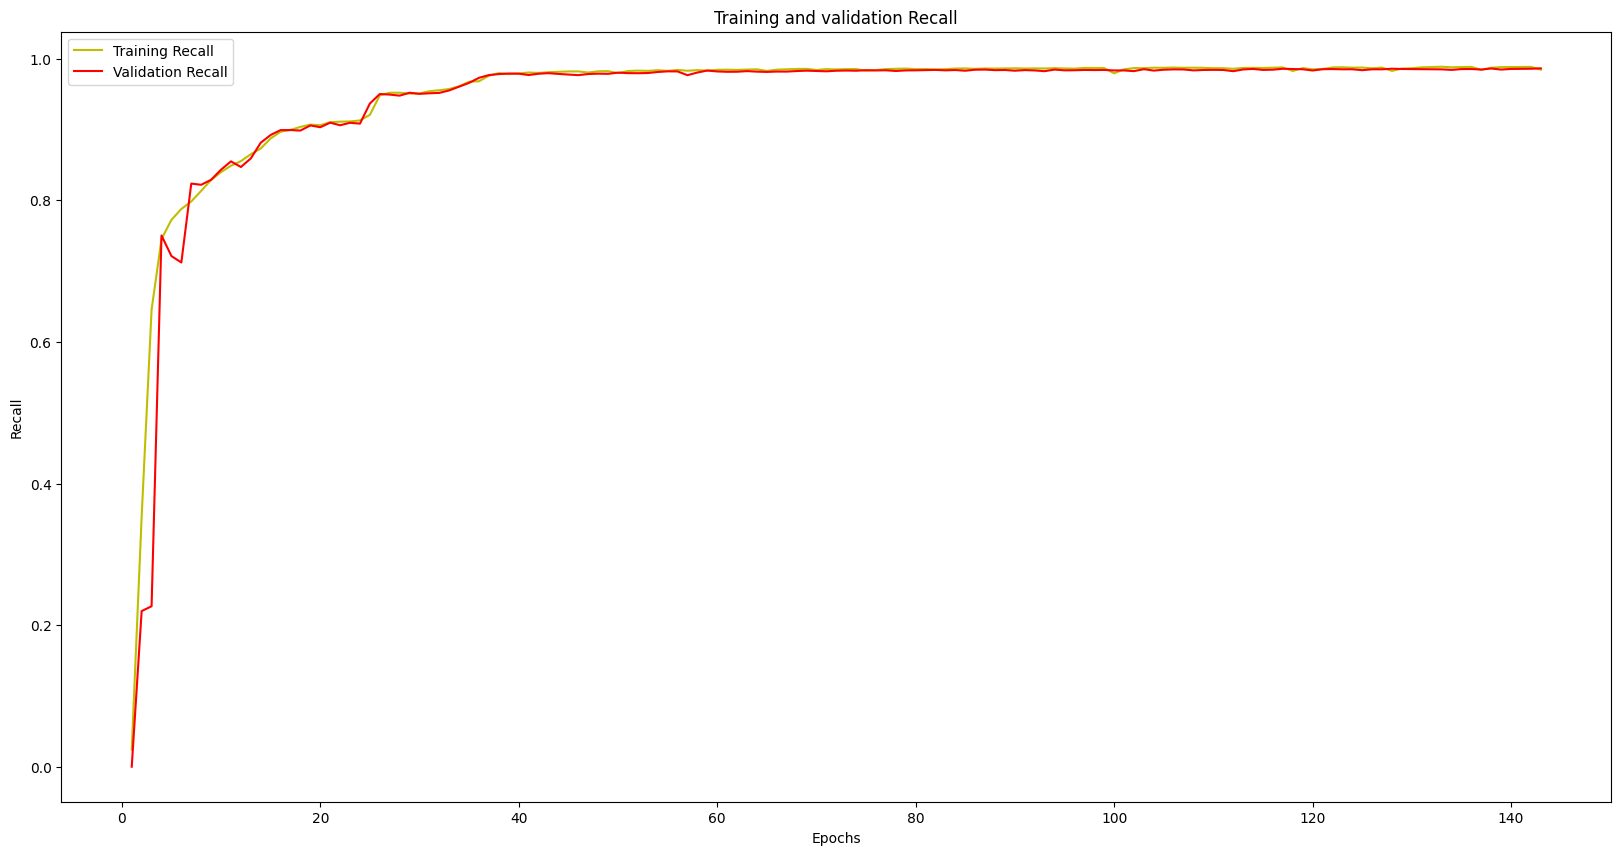

In [ ]:
pre_m = history1.history['recall_m']
val_pre_m = history1.history['val_recall_m']
plt.figure(figsize=(20, 10))
plt.plot(epochs, f1_m, 'y', label='Training Recall')
plt.plot(epochs, val_f1_m, 'r', label='Validation Recall')
plt.title('Training and validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.savefig('New_Models/Deeplabv3plus/Recall_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Recall_Deeplabv3plus.png', format='png')
plt.show()

1/1 [==============================] - 0s 23ms/step


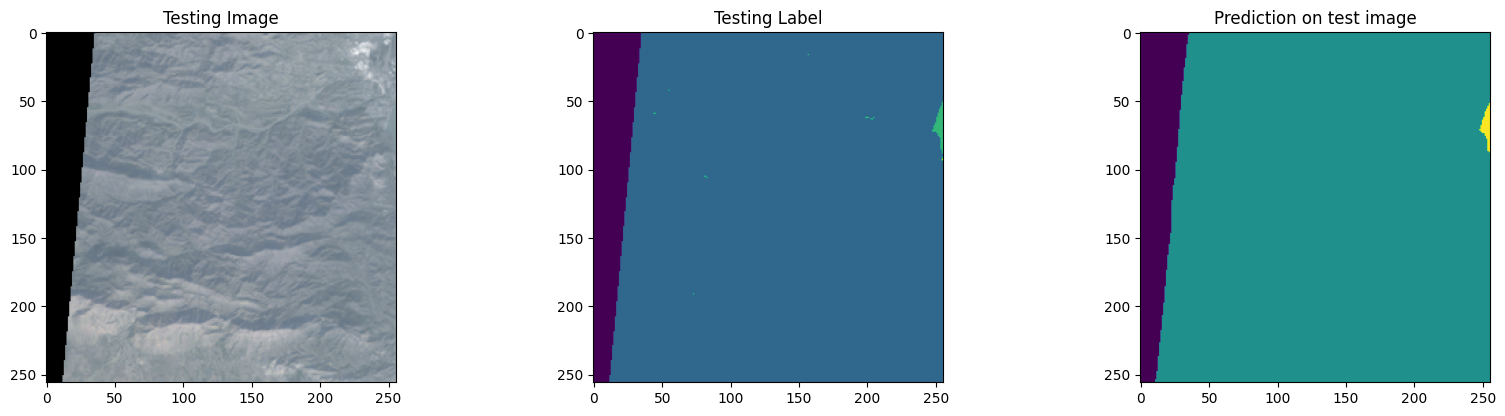

In [ ]:

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plot_image_R = np.array(test_img[:,:,3])
plot_image_G = np.array(test_img[:,:,2])
plot_image_B = np.array(test_img[:,:,1])
plot_image = np.dstack((plot_image_R, plot_image_G, plot_image_B))
test_img = (plot_image * 255.999) .astype(np.uint8)
plt.figure(figsize=(20, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(np.reshape(test_img, (patch_size, patch_size, 3)))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.savefig('New_Models/Deeplabv3plus/Prediction_Deeplabv3plus.svg', format='svg')
plt.savefig('New_Models/Deeplabv3plus/Prediction_Deeplabv3plus.png', format='png')
plt.show()

#####################################################################
